In [1]:
import torch
import torch.nn as nn
from dataloader import DataLoader

/home/anton/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMG_DIM = 28
MNIST_PATH = r"/home/anton/KTH/year5/5LSH0/mnist"
EPOCHS = 20
BATCH_SIZE = 10
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-8
CORRUPT_DATA = None

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),

        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [4]:
from torch.utils.tensorboard import SummaryWriter
from torch import optim
from torch.autograd import Variable
import time

torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder()
criterion = nn.MSELoss() 
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)
writer = SummaryWriter("runs/cnn_ae")

def train(loader, epochs):
    

    tic = time.perf_counter()

    for epoch in range(1, epochs+1):
        loss = 0
        for _, (images, labels) in enumerate(loader):
            train = Variable(images)
            labels = Variable(labels)
            reconstructed_image = model(train)
            loss = criterion(reconstructed_image, train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss += loss.item() 

        toc = time.perf_counter()
        time_format = time.strftime("%M:%S", time.gmtime(toc - tic))

        print(f"Time elapsed: {time_format}, epoch: {str(epoch).zfill(2)}/{epochs}, loss: {loss:.2f}")
        writer.add_scalar("Train_mse_loss", loss, epoch)
        writer.add_images("original_image", train.reshape(-1, IMG_DIM, IMG_DIM)[0], epoch, dataformats="HW")
        writer.add_images("reconstructed_image", reconstructed_image.reshape(-1, IMG_DIM, IMG_DIM)[0], epoch, dataformats="HW")

def evaluate(data_loader):
    with torch.no_grad():
        for _, (image, label) in enumerate(data_loader):
            # image = image.reshape(-1, IMG_DIM * IMG_DIM)            
            reconstructed_image = model(image)
    return image, reconstructed_image


2022-12-28 14:18:07.237004: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-28 14:18:07.237028: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
dl = DataLoader()
dl.prepareMNIST(mnist_path=MNIST_PATH, num_train_data=5000, num_normal_data=100, num_anomaly_data=100, corrupt_train=CORRUPT_DATA)
train_loader, normal_loader, anomaly_loader = dl.getDataLoaderMNIST(batch_size=500)


In [6]:
train(train_loader, epochs=EPOCHS)
writer.flush()

Time elapsed: 00:02, epoch: 01/20, loss: 0.33
Time elapsed: 00:08, epoch: 02/20, loss: 0.16
Time elapsed: 00:14, epoch: 03/20, loss: 0.08
Time elapsed: 00:19, epoch: 04/20, loss: 0.05
Time elapsed: 00:24, epoch: 05/20, loss: 0.03
Time elapsed: 00:28, epoch: 06/20, loss: 0.02
Time elapsed: 00:33, epoch: 07/20, loss: 0.02
Time elapsed: 00:37, epoch: 08/20, loss: 0.02
Time elapsed: 00:41, epoch: 09/20, loss: 0.01
Time elapsed: 00:45, epoch: 10/20, loss: 0.01
Time elapsed: 00:49, epoch: 11/20, loss: 0.01
Time elapsed: 00:53, epoch: 12/20, loss: 0.01
Time elapsed: 00:57, epoch: 13/20, loss: 0.01
Time elapsed: 01:01, epoch: 14/20, loss: 0.01
Time elapsed: 01:05, epoch: 15/20, loss: 0.01
Time elapsed: 01:09, epoch: 16/20, loss: 0.01
Time elapsed: 01:13, epoch: 17/20, loss: 0.01
Time elapsed: 01:16, epoch: 18/20, loss: 0.00
Time elapsed: 01:20, epoch: 19/20, loss: 0.00
Time elapsed: 01:24, epoch: 20/20, loss: 0.00


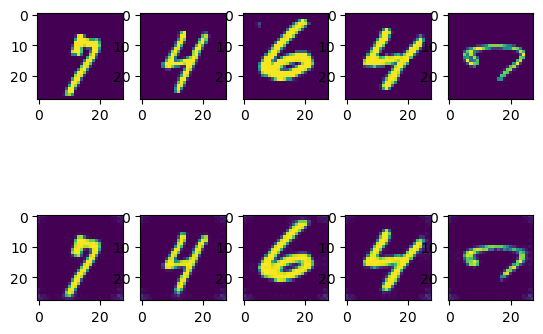

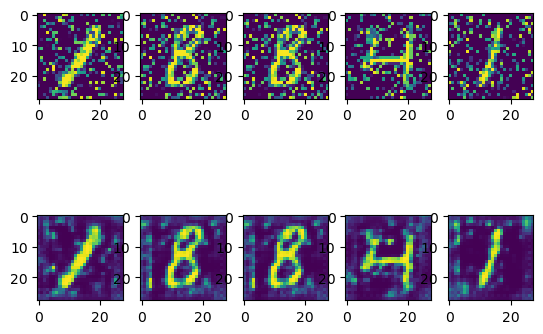

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
for i in range(1, 6):
        normal_image, reconstructed_normal_image = evaluate(normal_loader)
        fig.add_subplot(2, 5, i)
        plt.imshow(np.array(normal_image[0]).reshape(IMG_DIM, IMG_DIM))
        fig.add_subplot(2, 5, i+5)
        plt.imshow(np.array(reconstructed_normal_image[0]).reshape(IMG_DIM, IMG_DIM))

plt.savefig(f"regular_training_reconstruction_MNIST_noise_lvl_{'03'}_corrupt_train_data")
plt.show()
plt.close()

fig = plt.figure()
for i in range(1, 6):
        anomaly_image, reconstructed_anomaly_image = evaluate(anomaly_loader)
        fig.add_subplot(2, 5, i)
        plt.imshow(np.array(anomaly_image[0]).reshape(IMG_DIM, IMG_DIM))
        fig.add_subplot(2, 5, i+5)
        plt.imshow(np.array(reconstructed_anomaly_image[0]).reshape(IMG_DIM, IMG_DIM))

plt.savefig(f"regular_training_anomaly_reconstruction_MNIST_noise_lvl_{'03'}_corrupt_train_data")
plt.show()
plt.close()
